# Import statements

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import datetime
import json
import statsmodels.api as sm
import math

# Read in NYSE tickers, get 1000 largest companies, remove those with IPO after 12/31/2009 and those that yfinance has no data for, keep data starting from day at which all companies are publicly traded, and save data 

In [7]:
df = pd.read_csv('data/nyse_tickers.csv')
df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$126.97,-1.0900,-0.851%,3.754526e+10,United States,1999.0,733982,Industrials,Electrical Products
1,AA,Alcoa Corporation Common Stock,$35.28,-0.8600,-2.38%,6.292347e+09,NaN,2016.0,2083531,Industrials,Aluminum
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$10.43,0.0000,0.00%,0.000000e+00,NaN,2021.0,9816,Industrials,Metal Fabrications
3,AAIC,Arlington Asset Investment Corp Class A (new),$2.59,-0.0200,-0.766%,7.345356e+07,United States,NaN,3472,Real Estate,Real Estate Investment Trusts
4,AAIC^B,Arlington Asset Investment Corp 7.00%,$17.48,-0.0021,-0.012%,NaN,United States,NaN,100,NaN,NaN


In [8]:
df.dtypes

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

In [9]:
df.sort_values(by=['Market Cap'],ascending=False,inplace=True)
df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
450,BRK/A,Berkshire Hathaway Inc.,$490688.50,-1311.500,-0.267%,7.217410e+11,United States,NaN,4678,NaN,NaN
451,BRK/B,Berkshire Hathaway Inc.,$321.56,-1.430,-0.443%,7.094615e+11,United States,NaN,1132868,NaN,NaN
1474,JNJ,Johnson & Johnson Common Stock,$159.93,-1.720,-1.064%,4.989564e+11,United States,NaN,2526818,Health Care,Biotechnology: Pharmaceutical Preparations
2755,V,Visa Inc.,$230.67,-0.600,-0.259%,4.848190e+11,United States,NaN,1732859,Consumer Discretionary,Business Services
2721,UNH,UnitedHealth Group Incorporated Common Stock (DE),$486.815,-3.255,-0.664%,4.535181e+11,United States,NaN,1228681,Health Care,Medical Specialities


In [10]:
symbols = df.iloc[:1000,:]['Symbol'] #1000 symbols corresponding to largest companies on nyse

In [11]:
new = []
symbols = list(symbols)
for s in symbols:
    new.append(s.replace('^','-').replace('/','-').replace('.','-'))
symbols = new[:]

In [12]:
yf.Ticker('brk-b').history(period='max').head(1).index[0]

Timestamp('1996-05-09 00:00:00-0400', tz='America/New_York')

In [13]:
remove = []
for s in symbols:
    hist_df = yf.Ticker(s.upper()).history(period='max')
    if hist_df.shape[0] == 0:
        remove.append(s)
        continue
    year = hist_df.head(1).index[0].year
    if year >= 2010:
        remove.append(s)

In [14]:
symbols = set(symbols).difference(set(remove))

In [15]:
sym_str = ''
for s in symbols:
    sym_str+=s+' '
data = yf.download(sym_str,period='max')

[*********************100%***********************]  719 of 719 completed


In [16]:
for i in range(data.shape[0]):
    day = data.iloc[i,:]
    if True not in list(day.isna()):
        pts = day.name
        print(pts)
        break

2009-12-29 00:00:00


In [17]:
data = data.loc[pts:,:]

In [18]:
months = []
days = []
years = []
index = data.index
for date in index:
    months.append(date.month)
    days.append(date.day)
    years.append(date.year)
months = pd.Series(months,index=index)
years = pd.Series(years,index=index)
days = pd.Series(days,index=index)
data['Month'] = months
data['Day'] = days
data['Year'] = years
data.head()

Adj Close                                                        \
                    A         AA        AAP        AB        ABB        ABC   
Date                                                                          
2009-12-29  19.640221  35.237850  37.049263  9.560408  12.084814  21.653866   
2009-12-30  20.138828  35.831375  37.276485  9.712654  12.072253  21.604593   
2009-12-31  20.119404  35.435684  36.794739  9.723031  11.996881  21.407518   
2010-01-04  20.268343  36.600750  36.703854  9.826839  12.336060  21.867371   
2010-01-05  20.048174  35.457676  36.485683  9.816462  12.417715  21.711342   

                                                   ...     Volume              \
                ABEV    ABG        ABT        ACM  ...         WY           X   
Date                                               ...                          
2009-12-29  2.183233  11.78  19.265387  27.797506  ...   760100.0   8529900.0   
2009-12-30  2.174173  11.81  19.364799  27.402517  ...   647100.0   8010200.0   
2009-12-31  2.172915  11.53  19.169523  27.155645  ...   702000.0   3589500.0   
2010-01-04  2.264763  11.83  19.336399  27.797506  ...  1832400.0  10339400.0   
2010-01-05  2.249161  12.39  19.180187  28.103622  ...  1724500.0   9003200.0   

                                                             Month Day  Year  
                 XOM      XPO      YPF        YUM        ZBH                  
Date                                                                          
2009-12-29  19985700  69683.0   3600.0  2844734.0   607906.0    12  29  2009  
2009-12-30  19860600  18722.0   2600.0  1886196.0   594413.0    12  30  2009  
2009-12-31  18852300  36648.0  11300.0  1790217.0   579169.0    12  31  2009  
2010-01-04  27809100  28336.0   5100.0  2962274.0   805872.0     1   4  2010  
2010-01-05  30174700  44744.0   5300.0  3298757.0  1769643.0     1   5  2010  

[5 rows x 4317 columns]

In [19]:
data['Date']=pd.Series(data.index,index=data.index)

In [20]:
data.reset_index(drop=True,inplace=True)

In [21]:
data.columns

MultiIndex([('Adj Close',    'A'),
            ('Adj Close',   'AA'),
            ('Adj Close',  'AAP'),
            ('Adj Close',   'AB'),
            ('Adj Close',  'ABB'),
            ('Adj Close',  'ABC'),
            ('Adj Close', 'ABEV'),
            ('Adj Close',  'ABG'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'ACM'),
            ...
            (   'Volume',    'X'),
            (   'Volume',  'XOM'),
            (   'Volume',  'XPO'),
            (   'Volume',  'YPF'),
            (   'Volume',  'YUM'),
            (   'Volume',  'ZBH'),
            (    'Month',     ''),
            (      'Day',     ''),
            (     'Year',     ''),
            (     'Date',     '')],
           length=4318)

In [22]:
new_cols = []
cur_cols = list(data.columns)
for tup in cur_cols:
    if tup[1] == '':
        new_cols.append(tup[0])
    else:
        new_cols.append(tup[0]+': ' + tup[1])
data.columns = new_cols
data.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


In [23]:
data.to_csv('assets_data.csv',index=False)

# End

# Read in assets' data

In [24]:
assets_data = pd.read_csv('data/assets_data.csv')
assets_data.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


# End

# Get market data and save it

In [25]:
market_df = yf.Ticker('SPY').history(period='max')
market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0


In [26]:
months = []
days = []
years = []
index = market_df.index
new_index = []
for ts in index:
    new_index.append(ts.date())
for date in index:
    months.append(date.month)
    days.append(date.day)
    years.append(date.year)
months = pd.Series(months,index=index)
years = pd.Series(years,index=index)
days = pd.Series(days,index=index)
dates = pd.Series(new_index,index=index)
market_df['Month'] = months
market_df['Day'] = days
market_df['Year'] = years
market_df['Date'] = dates
market_df.reset_index(drop=True,inplace=True)

market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Month,Day,Year,Date
0,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0,1,29,1993,1993-01-29
1,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0,2,1,1993,1993-02-01
2,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0,2,2,1993,1993-02-02
3,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0,2,3,1993,1993-02-03
4,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0,2,4,1993,1993-02-04


In [27]:
market_df.to_csv('market_data.csv',index=False)

# End

# Read in market data

In [89]:
market_df = pd.read_csv('data/market_data.csv')
market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Month,Day,Year,Date
0,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0,1,29,1993,1993-01-29
1,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0,2,1,1993,1993-02-01
2,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0,2,2,1993,1993-02-02
3,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0,2,3,1993,1993-02-03
4,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0,2,4,1993,1993-02-04


# End

# Create monthly returns json and save it

In [29]:
monthly_asset_gb = assets_data.groupby(['Year','Month'])

In [30]:
monthly_market_gb = market_df.groupby(['Year','Month'])

In [100]:
monthly_rets = {}

for yr in range(2010,2024):
    monthly_rets[yr] = {}
    if yr < 2023:
        end_month = 13
    else:
        end_month = 5
    for month in range(1,end_month):
        group_indexer = (yr,month)
        monthly_rets[yr][month] = {}
        asset_gb = monthly_asset_gb.get_group(group_indexer)
        
        asset_first_day = asset_gb.head(1)
        asset_last_day = asset_gb.tail(1)
        
        for s in symbols:
            asset_month_open = asset_first_day['Open: ' + s].iloc[0]
            asset_month_close = asset_last_day['Adj Close: ' + s].iloc[0]
            asset_month_ret = (asset_month_close-asset_month_open)/asset_month_open
            monthly_rets[yr][month][s] = asset_month_ret

for yr in range(1994,2024):
    if yr < 2010:
        monthly_rets[yr] = {}
    if yr < 2023:
        end_month = 13
    else:
        end_month = 5
    for month in range(1,end_month):
        if yr < 2010:
            monthly_rets[yr][month] = {}
        group_indexer = (yr,month)
        market_gb = monthly_market_gb.get_group(group_indexer)
        market_first_day = market_gb.head(1)
        market_last_day = market_gb.tail(1)
        market_month_open = market_first_day['Open'].iloc[0]
        market_month_close = market_last_day['Close'].iloc[0]
        market_month_ret = (market_month_close-market_month_open)/market_month_open
        monthly_rets[yr][month]['Market'] = market_month_ret

In [101]:
#save monthly rets as json; yr -> month -> symbol -> return

with open('monthly_returns.json', 'w') as fp:
    json.dump(monthly_rets, fp, indent=3)

# End

# Read in monthly returns json

In [2]:
with open('data/monthly_returns.json', 'r') as fp:
    monthly_rets = json.load(fp)

# End

#  Create yearly returns json and save it

In [34]:
yearly_asset_gb = assets_data.groupby(['Year'])
yearly_market_gb = market_df.groupby(['Year'])

In [103]:
yearly_rets = {}
for yr in range(2010,2023):
    yearly_rets[yr] = {}
    asset_gp = yearly_asset_gb.get_group(yr)
    asset_first_day = asset_gp.head(1)
    asset_last_day = asset_gp.tail(1)

    for s in symbols:
        asset_open = asset_first_day['Open: ' + s].iloc[0]
        asset_close = asset_last_day['Adj Close: ' + s].iloc[0]
        asset_ret = (asset_close-asset_open)/asset_open
        yearly_rets[yr][s] = asset_ret

        
for yr in range(1994,2023):
    
    if yr < 2010:
        yearly_rets[yr] = {}
    
    market_gp = yearly_market_gb.get_group(yr)
    market_first_day = market_gp.head(1)
    market_last_day = market_gp.tail(1)
    market_open = market_first_day['Open'].iloc[0]
    market_close = market_last_day['Close'].iloc[0]
    market_ret = (market_close-market_open)/market_open
    yearly_rets[yr]['Market'] = market_ret

with open('yearly_returns.json', 'w') as fp:
    json.dump(yearly_rets, fp, indent=3)

# End 

# Read in yearly returns json

In [3]:
with open('data/yearly_returns.json', 'r') as fp:
    yearly_rets = json.load(fp)

# End

# Create symbols list

In [5]:
symbols = list(yearly_rets['2015'].keys())
symbols.remove('Market')

# End

# Plot beta and returns for monthly data

For each month, to get the current beta of an asset up to that month, regress prior months' returns for the asset on prior months' returns for the market (include an intercept term). Obviously, the return we want to associate with that beta is the return of the asset in that month.

In [54]:
monthly_beta_dict = {}
import warnings

warnings.simplefilter('error')

for s in symbols:
    #loop thru symbols
    s_ticker = yf.Ticker(s).history(period='max') #get hist data for asset
    index = s_ticker.index
    months = []
    days = []
    years = []
    for ts in index:
        months.append(ts.month)
        days.append(ts.day)
        years.append(ts.year)
    s_ticker['Month'] = pd.Series(months,index=index)
    s_ticker['Day'] = pd.Series(days,index=index)
    s_ticker['Year'] = pd.Series(years,index=index)
    s_ticker.reset_index(drop=True,inplace=True)
    s_gbo = s_ticker.groupby(['Year','Month'])
    
    earliest_month = s_ticker.head(1)['Month'].iloc[0]
    earliest_year = s_ticker.head(1)['Year'].iloc[0]
    
    market_returns = []
    asset_returns = []
    
    if earliest_year < 1994:
        earliest_year = 1994
        earliest_month = 1
    elif earliest_year == 1994:
        earliest_month = max(2,earliest_month)
    else:
        if earliest_month == 12:
            earliest_year+=1
            earliest_month=1
        else:
            earliest_month += 1
        
    #in chunk above, we determine the earliest month and year with respect to IPO of asset and IPO of SPY
    
    yr = 2011
    month = 1
    
    if yr not in monthly_beta_dict.keys():
        monthly_beta_dict[yr] = {}
        for i in range(1,13):
            monthly_beta_dict[yr][i] = {}
                
    #below, we loop thru all month-year combinations prior to Jan 2011 for which we have data for
    #both SPY and our asset, s and we append market returns and asset returns for each of these month-year combos
    #to a list
    for yr_iter in range(earliest_year, yr+1):
                
        if yr_iter == earliest_year:
            start_month = earliest_month
            month_iter_stop = 13
        elif yr_iter == yr:
            start_month = 1
            month_iter_stop = month
        else:
            start_month = 1
            month_iter_stop = 13

        for month_iter in range(start_month,month_iter_stop):

            #for yr,month loop thru all the yr_iter,month_iter combinations occuring prior to yr,month that we have data for

            market_returns.append(monthly_rets[str(yr_iter)][str(month_iter)]['Market'])
            s_gp = s_gbo.get_group((yr_iter,month_iter))
            s_gp_open = s_gp.head(1)['Open'].iloc[0]
            s_gp_close = s_gp.tail(1)['Close'].iloc[0]
            try:
                ret = (s_gp_close-s_gp_open)/s_gp_open
            except:
                if s_gp_open == 0:
                    s_gp_open = s_gp.head(1)['Close'].iloc[0]
                    ret = (s_gp_close-s_gp_open)/s_gp_open
                else:
                    raise Exception()
            asset_returns.append(ret)
    
    
    #compute Beta for asset s for Jan 2011
    res = sm.OLS(np.array(asset_returns).reshape(-1),sm.add_constant(np.array(market_returns).reshape((-1,1)))).fit()
    asset_beta = res.params[1]
    monthly_beta_dict[yr][month][s]=asset_beta
    
    
    for yr in range(2011,2024):
        
        if yr not in monthly_beta_dict.keys():
            monthly_beta_dict[yr] = {}
            for i in range(1,13):
                monthly_beta_dict[yr][i] = {}
            
        if yr < 2023:
            end_month = 13
        else:
            end_month = 5
            
        for month in range(1,end_month):
            
            
            #loop thru yr,month combinations for which we want to estimate the beta for s for that month
            
            if yr == 2011 and month == 1:
                continue #already computed beta for s for Jan 2011
                
            #in if-else block, we append only the last month's returns to the lists since we have computed beta for the 
            #past month in the prior iteration of the for loop 
            if month == 1:
                past_yr = yr-1
                past_month = 12
                market_returns.append(monthly_rets[str(past_yr)][str(past_month)]['Market'])
                s_gp = s_gbo.get_group((past_yr,past_month))
                s_gp_open = s_gp.head(1)['Open'].iloc[0]
                s_gp_close = s_gp.tail(1)['Close'].iloc[0]
                try:
                    ret = (s_gp_close-s_gp_open)/s_gp_open
                except:
                    if s_gp_open == 0:
                        s_gp_open = s_gp.head(1)['Close'].iloc[0]
                        ret = (s_gp_close-s_gp_open)/s_gp_open
                    else:
                        raise Exception()
                asset_returns.append(ret)
            else:
                past_month = month-1
                market_returns.append(monthly_rets[str(yr)][str(past_month)]['Market'])
                s_gp = s_gbo.get_group((yr,past_month))
                s_gp_open = s_gp.head(1)['Open'].iloc[0]
                s_gp_close = s_gp.tail(1)['Close'].iloc[0]
                try:
                    ret = (s_gp_close-s_gp_open)/s_gp_open
                except:
                    if s_gp_open == 0:
                        s_gp_open = s_gp.head(1)['Close'].iloc[0]
                        ret = (s_gp_close-s_gp_open)/s_gp_open
                    else:
                        raise Exception()
                asset_returns.append(ret)
            
            
            
            #compute beta for the year-month combo
            res = sm.OLS(np.array(asset_returns).reshape(-1),sm.add_constant(np.array(market_returns).reshape((-1,1)))).fit()
            asset_beta = res.params[1]
            
            monthly_beta_dict[yr][month][s]=asset_beta


# Save Monthly Beta dict to json

In [55]:
with open('monthly_beta.json', 'w') as fp:
    json.dump(monthly_beta_dict, fp, indent=3)

# End

# Read in Monthly Beta dict

In [56]:
with open('data/monthly_beta.json', 'r') as fp:
    monthly_beta_dict = json.load(fp)

# End

In [59]:
x = [] #beta of equities up to a certain month, m
y = [] #monthly returns for that same month, m

for s in symbols:
    for yr in range(2011,2024):
        if yr < 2023:
            for month in range(1,13):
                x.append(monthly_beta_dict[str(yr)][str(month)][s])
                y.append(monthly_rets[str(yr)][str(month)][s])
        else:
            for month in range(1,5):
                x.append(monthly_beta_dict[str(yr)][str(month)][s])
                y.append(monthly_rets[str(yr)][str(month)][s])

In [60]:
len(x) == len(y)

True

Text(0, 0.5, 'Monthly Returns')

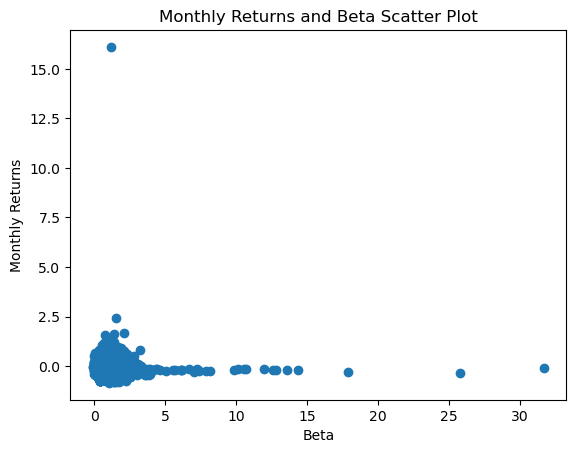

In [63]:
plt.scatter(x,y)
plt.title("Monthly Returns and Beta Scatter Plot")
plt.xlabel("Beta")
plt.ylabel("Monthly Returns")

In [64]:
res = sm.OLS(np.array(y).reshape(-1),sm.add_constant(np.array(x).reshape((-1,1)))).fit()

In [65]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     648.2
Date:                Sun, 14 May 2023   Prob (F-statistic):          1.45e-142
Time:                        18:22:21   Log-Likelihood:                 46780.
No. Observations:              106412   AIC:                        -9.356e+04
Df Residuals:                  106410   BIC:                        -9.354e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1445      0.001   -129.395      0.000      -0.147      -0.142
x1             0.0246      0.001     25.460      0.000       0.023       0.026
==============================================================================
Omnibus:                   181063.495   Durbin-Watson:                   0.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5396201245.360
Skew:                          10.439   Prob(JB):                         0.00
Kurtosis:                    1106.003   Cond. No.                         4.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
np.corrcoef(np.column_stack((np.array(x),np.array(y))),rowvar=False)

array([[1.        , 0.07781332],
       [0.07781332, 1.        ]])

Correlation coefficient of 0.08 indicates some weak positive linear association between beta and monthly returns

# End

# Plot beta and returns for yearly data

For each year, to get the current beta of an asset up to that year, regress prior years' returns for the asset on prior years' returns for the market (include an intercept term). Obviously, the return we want to associate with that beta is the return of the asset in that year.

In [75]:
yearly_beta_dict = {}

for s in symbols:
    #loop thru symbols
    it_idx = symbols.index(s)
    if it_idx % 100 == 0:
        print(it_idx)
    s_ticker = yf.Ticker(s).history(period='max') #get hist data for asset
    index = s_ticker.index
    months = []
    days = []
    years = []
    for ts in index:
        months.append(ts.month)
        days.append(ts.day)
        years.append(ts.year)
    s_ticker['Month'] = pd.Series(months,index=index)
    s_ticker['Day'] = pd.Series(days,index=index)
    s_ticker['Year'] = pd.Series(years,index=index)
    s_ticker.reset_index(drop=True,inplace=True)
    s_gbo = s_ticker.groupby(['Year'])
    
   
    earliest_year = s_ticker.head(1)['Year'].iloc[0] 
    
    if earliest_year < 1994:
        earliest_year = 1994
    else:
        earliest_year += 1
        
    #in chunk above, we determine the earliest year with respect to IPO of asset and IPO of SPY
    
    market_returns = []
    asset_returns = []
    
    yr = 2012 
    
    if yr not in yearly_beta_dict.keys():
        yearly_beta_dict[yr] = {}
    
    for yr_iter in range(earliest_year, yr):    

        #for yr loop thru all the yr_iter instances occuring prior to yr that we have data for
        market_returns.append(yearly_rets[str(yr_iter)]['Market'])
        s_gp = s_gbo.get_group(yr_iter)
        s_gp_open = s_gp.head(1)['Open'].iloc[0]
        s_gp_close = s_gp.tail(1)['Close'].iloc[0]
        try:
            ret = (s_gp_close-s_gp_open)/s_gp_open
        except:
            if s_gp_open == 0:
                s_gp_open = s_gp.head(1)['Close'].iloc[0]
                ret = (s_gp_close-s_gp_open)/s_gp_open
            else:
                raise Exception()
        asset_returns.append(ret)
        
    res = sm.OLS(np.array(asset_returns).reshape(-1),sm.add_constant(np.array(market_returns).reshape((-1,1)))).fit()
    asset_beta = res.params[1]
    yearly_beta_dict[yr][s]=asset_beta
    
    for yr in range(2013,2023):
        
        if yr not in yearly_beta_dict.keys():
            yearly_beta_dict[yr] = {}
            

        market_returns.append(yearly_rets[str(yr-1)]['Market'])
        s_gp = s_gbo.get_group(yr-1)
        s_gp_open = s_gp.head(1)['Open'].iloc[0]
        s_gp_close = s_gp.tail(1)['Close'].iloc[0]
        try:
            ret = (s_gp_close-s_gp_open)/s_gp_open
        except:
            if s_gp_open == 0:
                s_gp_open = s_gp.head(1)['Close'].iloc[0]
                ret = (s_gp_close-s_gp_open)/s_gp_open
            else:
                raise Exception()
        asset_returns.append(ret)

        res = sm.OLS(np.array(asset_returns).reshape(-1),sm.add_constant(np.array(market_returns).reshape((-1,1)))).fit()
        asset_beta = res.params[1]

        yearly_beta_dict[yr][s]=asset_beta



0


Exception ignored in: <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET6, type=SocketKind.SOCK_STREAM, proto=0, laddr=('2600:4040:77da:5400:c51d:92e1:5357:2e78', 53430, 0, 0), raddr=('2001:4998:1c:800::1001', 443, 0, 0)>
Traceback (most recent call last):
  File "/Users/irfanjamil/anaconda3/envs/standard_env/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py", line 578, in __iter__
    converted = ints_to_pydatetime(


100
200
300
400
500
600
700


# Save yearly beta dict to json

In [76]:
with open('yearly_beta.json', 'w') as fp:
    json.dump(yearly_beta_dict, fp, indent=3)

# End

# Read in yearly beta dict

In [77]:
with open('data/yearly_beta.json', 'r') as fp:
    yearly_beta_dict = json.load(fp)

# End

In [78]:
x = [] #beta of equities up to a certain year, y
y = [] #yearly returns for that same year, y

for s in symbols:
    for yr in range(2012,2023):
        x.append(yearly_beta_dict[str(yr)][s])
        y.append(yearly_rets[str(yr)][s])

In [79]:
len(x) == len(y)

True

Text(0, 0.5, 'Annual Returns')

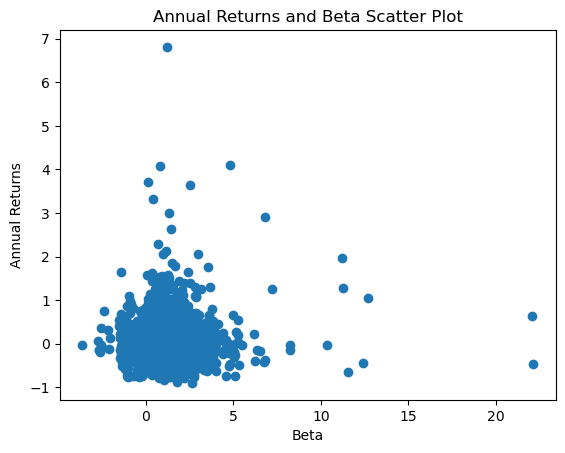

In [80]:
plt.scatter(x,y)
plt.title("Annual Returns and Beta Scatter Plot")
plt.xlabel("Beta")
plt.ylabel("Annual Returns")

In [81]:
res = sm.OLS(np.array(y).reshape(-1),sm.add_constant(np.array(x).reshape((-1,1)))).fit()

In [82]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.55
Date:                Sun, 14 May 2023   Prob (F-statistic):           2.83e-05
Time:                        18:44:39   Log-Likelihood:                -2745.7
No. Observations:                7909   AIC:                             5495.
Df Residuals:                    7907   BIC:                             5509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0205      0.006     -3.706      0.000      -0.031      -0.010
x1             0.0180      0.004      4.189      0.000       0.010       0.026
==============================================================================
Omnibus:                     5637.129   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353417.071
Skew:                           2.788   Prob(JB):                         0.00
Kurtosis:                      35.270   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
np.corrcoef(np.column_stack((np.array(x),np.array(y))),rowvar=False)

array([[1.        , 0.04706084],
       [0.04706084, 1.        ]])

Correlation coefficientt of 0.047 implies very, very, very weak positive linear association between beta and annual returns; essentially, no linear association

# CAPM analysis -- using annual returns

CAPM states that the expected return of an equity is the sum of risk-free rate and beta of the equity times. the expected risk premium of the market versus the risk free rate 

In [84]:
rf_df = yf.Ticker('^IRX').history(period='max')
rf_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1960-01-04 00:00:00-05:00,4.52,4.52,4.52,4.52,0,0.0,0.0
1960-01-05 00:00:00-05:00,4.55,4.55,4.55,4.55,0,0.0,0.0
1960-01-06 00:00:00-05:00,4.68,4.68,4.68,4.68,0,0.0,0.0
1960-01-07 00:00:00-05:00,4.63,4.63,4.63,4.63,0,0.0,0.0
1960-01-08 00:00:00-05:00,4.59,4.59,4.59,4.59,0,0.0,0.0


In [85]:
index = list(rf_df.index)
months = []
years = []
days = []
dates = []

for ts in index:
    months.append(ts.month)
    years.append(ts.year)
    days.append(ts.day)
    dates.append(ts.date())

month_ser = pd.Series(months,index=index)
year_ser = pd.Series(years,index=index)
day_ser = pd.Series(days,index=index)
date_ser = pd.Series(dates,index=index)

rf_df['Month'] = month_ser
rf_df['Day'] = day_ser
rf_df['Year'] = year_ser
rf_df['Date'] = date_ser

rf_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Month,Day,Year,Date
Date,,,,,,,,,,,
1960-01-04 00:00:00-05:00,4.52,4.52,4.52,4.52,0,0.0,0.0,1,4,1960,1960-01-04
1960-01-05 00:00:00-05:00,4.55,4.55,4.55,4.55,0,0.0,0.0,1,5,1960,1960-01-05
1960-01-06 00:00:00-05:00,4.68,4.68,4.68,4.68,0,0.0,0.0,1,6,1960,1960-01-06
1960-01-07 00:00:00-05:00,4.63,4.63,4.63,4.63,0,0.0,0.0,1,7,1960,1960-01-07
1960-01-08 00:00:00-05:00,4.59,4.59,4.59,4.59,0,0.0,0.0,1,8,1960,1960-01-08


In [86]:
rf_df.reset_index(drop=True,inplace=True)
rf_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Month,Day,Year,Date
0,4.52,4.52,4.52,4.52,0,0.0,0.0,1,4,1960,1960-01-04
1,4.55,4.55,4.55,4.55,0,0.0,0.0,1,5,1960,1960-01-05
2,4.68,4.68,4.68,4.68,0,0.0,0.0,1,6,1960,1960-01-06
3,4.63,4.63,4.63,4.63,0,0.0,0.0,1,7,1960,1960-01-07
4,4.59,4.59,4.59,4.59,0,0.0,0.0,1,8,1960,1960-01-08


In [88]:
rf_gbo = rf_df.groupby(['Year','Month'])
rf_dict = {} #maps year to rf rate in percent

#extract rf rates for 2012-2022
for year in range(2011,2022):
    rf_gp_nov = rf_gbo.get_group((year,11))
    rf_gp_dec = rf_gbo.get_group((year,12))
    nov_close = np.array(rf_gp_nov['Close'])
    dec_close = np.array(rf_gp_dec['Close'])
    close = list(nov_close) + list(dec_close)
    avg_close = sum(close)/len(close)
    rf_dict[year+1]  = avg_close 
    

rf_dict maps the year to the risk free rate as a percent; the prior years' last 2 months average close was used to calculate the risk free rate for the year

We need to compute expected annual market returns too. Let's use the past 5 years of market data to compute the expected return for a given year.

In [90]:
market_gbo = market_df.groupby(['Year'])
market_ret_dict = {}
for yr in range(2006,2023):
    #compute return for the yr
    year_group = market_gbo.get_group(yr)
    fd = year_group.head(1)
    ld = year_group.tail(1)
    fopen = fd['Open'].iloc[0]
    lclose = ld['Close'].iloc[0]
    ret = (lclose-fopen)/fopen
    market_ret_dict[yr]=ret

market_ret_dict maps the year to the return of SPY over the course of the year

In [91]:
exp_ret_dict = {}

for yr in range(2012,2023):
    rf_rate = rf_dict[yr]/100
    exp_ret_dict[yr] = {}
    for s in symbols:
        beta = yearly_beta_dict[str(yr)][s]
        start_yr = yr - 5
        arr_mark_rets = []
        for yr_it in range(start_yr,yr):
            arr_mark_rets.append(market_ret_dict[yr_it])
        exp_mark_ret = sum(arr_mark_rets)/len(arr_mark_rets)
        exp_ret = rf_rate + beta*(exp_mark_ret-rf_rate)
        exp_ret_dict[yr][s] = exp_ret
        

In [92]:
x = [] #expected returns 
y = [] #actual returns

for yr in range(2012,2023):
    for s in symbols:
        x.append(exp_ret_dict[yr][s])
        y.append(yearly_rets[str(yr)][s])

Text(0, 0.5, 'Actual Returns')

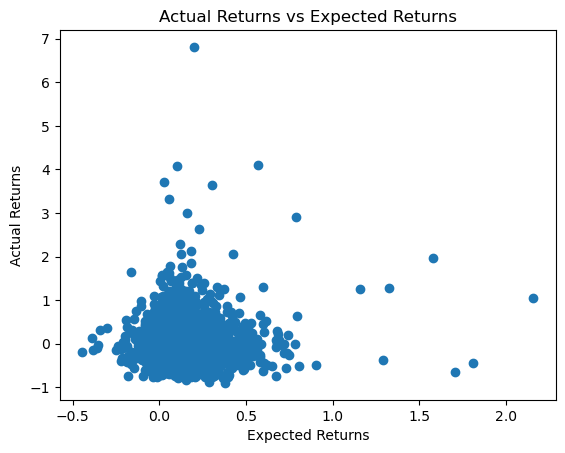

In [93]:
plt.scatter(x,y)
plt.title("Actual Returns vs Expected Returns")
plt.xlabel("Expected Returns")
plt.ylabel("Actual Returns")

In [94]:
res = sm.OLS(np.array(y).reshape(-1),np.array(x).reshape((-1,1))).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2114
Date:                Sun, 14 May 2023   Prob (F-statistic):                       0.646
Time:                        18:48:47   Log-Likelihood:                         -2754.9
No. Observations:                7909   AIC:                                      5512.
Df Residuals:                    7908   BIC:                                      5519.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0111      0.024     -0.460      0.646      -0.058       0.036
==============================================================================
Omnibus:                     5702.746   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           360714.457
Skew:                           2.838   Prob(JB):                         0.00
Kurtosis:                      35.594   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
np.corrcoef(np.column_stack((np.array(x),np.array(y))),rowvar=False)

array([[1.        , 0.00397455],
       [0.00397455, 1.        ]])

Low correlation coefficient and a slope far away from 1 indicate that expected and actual annual returns are not close to being equivalent. The data actually supports no relationship!